In [1]:
from src.dataset import AnimeAudioDataset
from src.net import Net

import torchaudio
import torch
import os

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib notebook
import matplotlib.pyplot as plt

device = torch.device("cuda")

## Load Data

In [2]:
dataset = AnimeAudioDataset(audio_dir="data/Audio",
                         label_dir="data/Labels",
                         device=device,
                         load_all_in_mem=False)

In [3]:
validation_split = 0.2

val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])

## Define Network

In [4]:
batch_size = 5
net = Net(dataset.max_length, batch_size)
net.cuda()
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0)

# Train

<IPython.core.display.Javascript object>


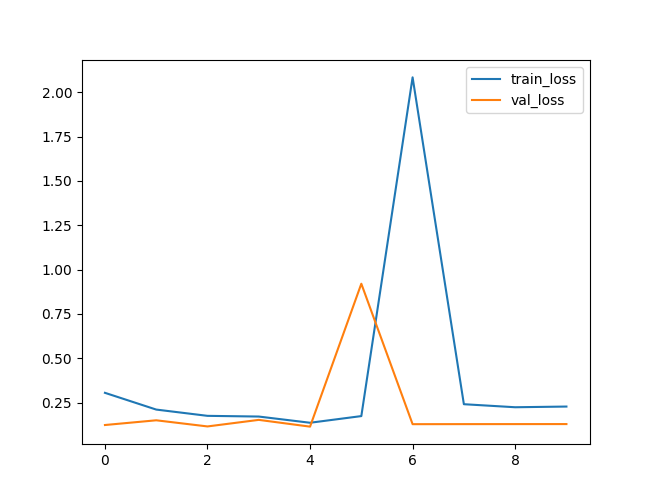

train_loss: 0.30577079034768617
val_loss: 0.12432594100634257
train_loss: 0.2113826544238971
val_loss: 0.15095312893390656
train_loss: 0.1760462877842096
val_loss: 0.11634850005308787
train_loss: 0.1720899652976256
val_loss: 0.15335671603679657
train_loss: 0.13708040089561388
val_loss: 0.11517504354317983
train_loss: 0.17465460859239101
val_loss: 0.9206065138181051
train_loss: 2.0836519174850903
val_loss: 0.12909779449303946
train_loss: 0.24162166508344504
val_loss: 0.12937460343043009
train_loss: 0.22449320325484642
val_loss: 0.12952293455600739
train_loss: 0.228388477403384
val_loss: 0.12967326740423837


In [5]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

train_loss_arr = []
val_loss_arr = []

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for epoch in range(10):

    train_loss = 0
    val_loss = 0

    for data, label in train_dataloader:

        optimizer.zero_grad()

        output = net(data)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    for data, label in val_dataloader:
        output = net(data)
        loss = criterion(output, label)
        val_loss += loss.item()
        
    train_loss /= len(train_data)
    val_loss /= len(val_data)
    
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)
    
    ax.clear()
    ax.plot(train_loss_arr, label="train_loss")
    ax.plot(val_loss_arr, label="val_loss")
    ax.legend()
    fig.canvas.draw()
    
    print("train_loss:", train_loss)
    print("val_loss:", val_loss)

# Compare actual labels

In [ ]:
label_1 = "data/Labels/nick/One_Punch_Man_1.label"
label_2 = "data/Labels/nick/One_Punch_Man_5.label"
label_3 = "data/Labels/nick/One_Punch_Man_6.label"

labels = []
for filename in [label_1, label_2, label_3]:
    f = open(filename, "r")
    label = []
    for i in range(4):
        label.append(int(f.readline()))
    labels.append(label)

labels = torch.Tensor(labels)
labels = labels.to(device)

In [ ]:
for i in range(len(anime_audio_data.audio_files)):
    if anime_audio_data.audio_files[i].startswith('One'):
        print(anime_audio_data.audio_files[i], i)

In [ ]:
'''
for i, data in enumerate(anime_audio_data):
    data, _ = data
    #data = data.unsqueeze(0)
    out = net(data) * anime_audio_data.l_std.to(device) + anime_audio_data.l_mean.to(device)
    print(out)
    print(labels[i])
'''
def temp(data):
    audio, label = data
    out = net(audio.unsqueeze(0)) * anime_audio_data.l_std.to(device) + anime_audio_data.l_mean.to(device)
    label = label * anime_audio_data.l_std.to(device) + anime_audio_data.l_mean.to(device)
    print(out)
    print(label)
temp(anime_audio_data[2])
temp(anime_audio_data[3])
temp(anime_audio_data[4])